# **Image Classification Task**

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Download Dataset from Kaggle**

In [3]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.52GB/s]


In [5]:
!unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


## **2. Imports**

In [6]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

## **3. Configuration**

In [7]:
TRAIN_CSV = "/content/fashion-mnist_train.csv"
TEST_CSV = "/content/fashion-mnist_test.csv"

BATCH_SIZE = 64
IMG_SIZE = 28        # Fashion-MNIST images are 28x28
VAL_SPLIT = 0.2
EPOCHS = 5
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
NUM_CLASSES = len(CLASS_NAMES)

## **4. Custom Dataset Class**

In [8]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None): # run once when instantiating the Dataset object.
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self): # returns the number of samples in our dataset.
        return len(self.data)

    def __getitem__(self, idx): # returns a sample from the dataset at the given index idx
        row = self.data.iloc[idx]
        label = int(row[0])
        pixels = row[1:].to_numpy(dtype="uint8").reshape(28, 28)
        img = torch.tensor(pixels, dtype=torch.float32).unsqueeze(0)  # 1 x 28 x 28
        if self.transform:
            img = self.transform(img)
        return img, label

## **5. Transforms**

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),   # Resize image to fixed size
    transforms.ToTensor(),                     # Convert PIL image to PyTorch tensor
    transforms.Normalize([0.5], [0.5])        # Scale pixel values from [0,1] to [-1,1]
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),   # Resize image
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize([0.5], [0.5])        # Normalize to [-1,1]
])

## **6. Dataset Split and DataLoaders**

In [10]:
full_dataset = FashionMNISTDataset(TRAIN_CSV, transform=train_transform)
dataset_size = len(full_dataset)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

# pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = FashionMNISTDataset(TEST_CSV, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## **7. Model: Simple CNN**

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 1x28x28 -> 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 32x14x14
            nn.Conv2d(32, 64, 3, padding=1), # 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(2)                  # 64x7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(DEVICE)

## **8. Training Setup**

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## **9. Training & Validation Loop**

In [13]:
for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, "
          f"Val Loss = {val_loss/len(val_loader):.4f}, "
          f"Val Acc = {100 * correct/total:.2f}%")

Epoch 1/5 [Train]:   0%|          | 0/750 [00:00<?, ?it/s]/tmp/ipython-input-2444328708.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = int(row[0])
Epoch 1/5 [Val]: 100%|██████████| 188/188 [00:06<00:00, 28.45it/s]


Epoch 1: Train Loss = 0.8163, Val Loss = 0.3875, Val Acc = 86.18%


Epoch 2/5 [Val]: 100%|██████████| 188/188 [00:06<00:00, 30.40it/s]


Epoch 2: Train Loss = 0.3341, Val Loss = 0.3460, Val Acc = 87.30%


Epoch 3/5 [Val]: 100%|██████████| 188/188 [00:06<00:00, 31.16it/s]


Epoch 3: Train Loss = 0.2871, Val Loss = 0.3167, Val Acc = 88.41%


Epoch 4/5 [Val]: 100%|██████████| 188/188 [00:06<00:00, 29.20it/s]


Epoch 4: Train Loss = 0.2588, Val Loss = 0.3359, Val Acc = 88.53%


Epoch 5/5 [Val]: 100%|██████████| 188/188 [00:06<00:00, 30.83it/s]

Epoch 5: Train Loss = 0.2365, Val Loss = 0.3336, Val Acc = 88.59%


## **10. Validation set evaluation**

/tmp/ipython-input-2444328708.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = int(row[0])


Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.77      0.83      1252
     Trouser       0.98      0.98      0.98      1125
    Pullover       0.86      0.78      0.82      1215
       Dress       0.88      0.91      0.89      1198
        Coat       0.83      0.74      0.79      1215
      Sandal       0.96      0.98      0.97      1171
       Shirt       0.62      0.82      0.71      1189
     Sneaker       0.95      0.95      0.95      1228
         Bag       0.98      0.97      0.97      1204
  Ankle boot       0.97      0.96      0.96      1203

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000



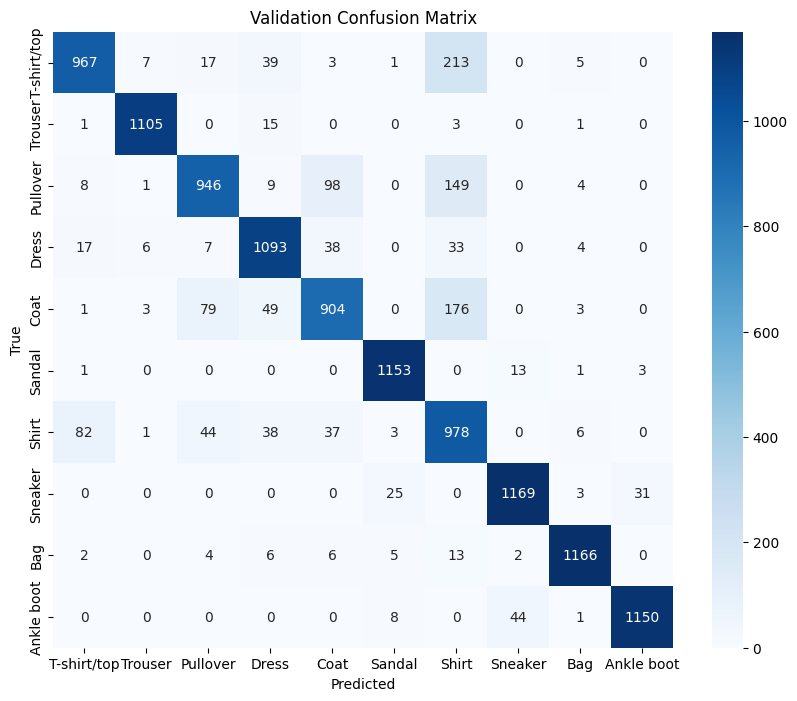

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on Validation Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()


## **11. Test evaluation**

In [14]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"✅ Test Accuracy: {100 * correct / total:.2f}%")

Testing:   0%|          | 0/157 [00:00<?, ?it/s]/tmp/ipython-input-2444328708.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = int(row[0])
Testing: 100%|██████████| 157/157 [00:05<00:00, 27.59it/s]

✅ Test Accuracy: 89.12%
